# Building A Multi Layer Perceptron

## Building Training Dataset

In [117]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plot
%matplotlib inline
import random

In [9]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
len(words)

32033

In [11]:
# build vocab and mappings
chars = sorted(list(set(''.join(words))))
chtoi ={ch:i+1 for i, ch in enumerate(chars)} # char to int mapping
chtoi['.'] = 0 # add separator
itoch = {i:ch for ch, i in chtoi.items()} # int to char mapping
print(itoch)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [12]:
# building the dataset
block_size = 3 

`block_size` represents the context length i.e. how many characters does the model take to predict the next one.

In [13]:
X, Y = [], []

for w in words[:3]:
    print(w)
    context = [0] * block_size ## start with padded context of 0s
    for ch in w + '.':
        ix = chtoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itoch[i] for i in context), '->', itoch[ix])
        context = context[1:] + [ix] # update the context window

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .


In [14]:
print(f'inputs:\n{X}\n')
print(f'targets:\n{Y}\n')

inputs:
[[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [0, 0, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9], [22, 9, 1], [0, 0, 0], [0, 0, 1], [0, 1, 22], [1, 22, 1]]

targets:
[5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0, 1, 22, 1, 0]



In [15]:
X = torch.tensor(X)
Y = torch.tensor(Y)

Notice that out of the word "emma" we can generate 5 different example for inputs and targets.

In [16]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

## Building The Embedding Table

In [17]:
C = torch.randn((27, 2)) # creating a 2D vector space for a 27 token vocab size
C 

tensor([[-0.7139,  0.3497],
        [ 0.5407, -0.7839],
        [ 0.4091, -1.1315],
        [-0.7191, -0.0769],
        [ 0.0222,  0.3191],
        [-1.2853, -0.4953],
        [ 0.7021, -0.1104],
        [ 2.0897, -0.7917],
        [-0.7046, -1.7147],
        [ 0.0570, -0.8869],
        [-1.6141,  0.7676],
        [-0.7819, -1.9523],
        [ 0.7117,  0.5099],
        [ 0.6509,  0.6420],
        [-0.7769,  0.7733],
        [ 1.8286, -1.0109],
        [-1.1643, -0.8813],
        [ 0.0635, -0.2068],
        [ 0.3117,  1.3292],
        [ 0.2380, -1.1240],
        [-0.2097, -0.0998],
        [-0.4272, -0.4513],
        [ 0.5003,  0.9672],
        [ 1.2639,  0.3094],
        [-0.5654, -0.0813],
        [-2.3500,  0.7216],
        [ 0.1687,  0.2044]])

Embedding a single integer in the embedding lookup table

In [18]:
C[5] # row corresponsding to index 5 in the embedding table

tensor([-1.2853, -0.4953])

In [19]:
F.one_hot(torch.tensor(5), num_classes=27) # encoding integer 5 to a vector

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [20]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.2853, -0.4953])

Notice that the output is identical. Because of all the 0s in the one-hot vector, all other values in C get masked out except for the row corresponding to the integer i.e. index 5. 

So the embedding of an integer can either be seen as the integer indexing into a lookup table C or it can be seen as the first layer of a larger NN. The neurons in this layer have no non-linearity and their weight matrix is C. We are encoding ints in one-hot and then feeding them to this layer.

Getting embeddings of multiple integers

In [21]:
C[[5, 6, 7]]

tensor([[-1.2853, -0.4953],
        [ 0.7021, -0.1104],
        [ 2.0897, -0.7917]])

In [22]:
C[torch.tensor([5, 6, 7])]

tensor([[-1.2853, -0.4953],
        [ 0.7021, -0.1104],
        [ 2.0897, -0.7917]])

In [23]:
# we can also index with multi dim tensors
C[X][:3]

tensor([[[-0.7139,  0.3497],
         [-0.7139,  0.3497],
         [-0.7139,  0.3497]],

        [[-0.7139,  0.3497],
         [-0.7139,  0.3497],
         [-1.2853, -0.4953]],

        [[-0.7139,  0.3497],
         [-1.2853, -0.4953],
         [ 0.6509,  0.6420]]])

In [24]:
X.shape

torch.Size([16, 3])

In [25]:
C[X].shape # for everyone of the vectors in X we have a 2D embedding

torch.Size([16, 3, 2])

In [26]:
# example 
print(X[13, 2])
print(C[X][13, 2])
print(C[1])

tensor(1)
tensor([ 0.5407, -0.7839])
tensor([ 0.5407, -0.7839])


In [27]:
# so embedding all ints
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

## Implementing The Hidden Layer

According to the paper we have 3 inputs of (in our case) 2 dims so the number of inputs for this layer is 6. Let's take the number of neurons in this layer to be 100 (upto us).

In [28]:
W1 = torch.randn((6, 100)) # weights
B1 = torch.randn(100) # biases

We want to do the operation `emb @ W + b` but the embeddings are stacked in the input tensor so matmul will not work. So we need to concatenate these inputs together i.e. convert 16, 3, 2 to a 16, 6 tensor.

In [29]:
emb[:, 0, :].shape # get everything at the 0 index

torch.Size([16, 2])

In [30]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concatenate the seq across dim 1

torch.Size([16, 6])

In [31]:
# to generalize the above operation
len(torch.unbind(emb, 1)) # list of tensors as in the above operation

3

In [32]:
# so now we can do the general operation
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([16, 6])

Turns out there is an even better way of doing this.

In [33]:
example = torch.arange(18)
example

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [34]:
# we can represent example tensor in different sized n dim tensors
example.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [35]:
example.view(3, 3, 2) # product of dim numbers should be the same

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In pytorch `.view` operation is extremely efficient because a tensor is stored as a 1D sequence of bytes in memory and the attributes of the tensor add the dimesionality to it. When we call `.view` we only modify these attributes but the underlying tensor remains the same.

In [36]:
emb.shape

torch.Size([16, 3, 2])

In [37]:
emb.view(16, 6)

tensor([[-0.7139,  0.3497, -0.7139,  0.3497, -0.7139,  0.3497],
        [-0.7139,  0.3497, -0.7139,  0.3497, -1.2853, -0.4953],
        [-0.7139,  0.3497, -1.2853, -0.4953,  0.6509,  0.6420],
        [-1.2853, -0.4953,  0.6509,  0.6420,  0.6509,  0.6420],
        [ 0.6509,  0.6420,  0.6509,  0.6420,  0.5407, -0.7839],
        [-0.7139,  0.3497, -0.7139,  0.3497, -0.7139,  0.3497],
        [-0.7139,  0.3497, -0.7139,  0.3497,  1.8286, -1.0109],
        [-0.7139,  0.3497,  1.8286, -1.0109,  0.7117,  0.5099],
        [ 1.8286, -1.0109,  0.7117,  0.5099,  0.0570, -0.8869],
        [ 0.7117,  0.5099,  0.0570, -0.8869,  0.5003,  0.9672],
        [ 0.0570, -0.8869,  0.5003,  0.9672,  0.0570, -0.8869],
        [ 0.5003,  0.9672,  0.0570, -0.8869,  0.5407, -0.7839],
        [-0.7139,  0.3497, -0.7139,  0.3497, -0.7139,  0.3497],
        [-0.7139,  0.3497, -0.7139,  0.3497,  0.5407, -0.7839],
        [-0.7139,  0.3497,  0.5407, -0.7839,  0.5003,  0.9672],
        [ 0.5407, -0.7839,  0.5003,  0.9

So we can get the hidden states of the hidden layer by:

In [38]:
h = emb.view(16, 6) @ W1 + B1

In [39]:
h.shape

torch.Size([16, 100])

In [40]:
# we're still hardcoding emb's dimensionality so to fix that we can do
h = emb.view(-1, 6) @ W1 + B1 # -1 means pytorch can derive the appropriate dim

So now we perform a `tanh` (from the paper) to get the 100 dimensional activations of all of our 16 examples.

In [41]:
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)

## Implementing The Output Layer

In [42]:
W2 = torch.randn((100, 27)) # input is 100 and output number of neurons is 27 for our vocab size
B2 = torch.randn(27)

In [43]:
logits = h @ W2 + B2

In [44]:
logits.shape

torch.Size([16, 27])

In [45]:
# getting prob dist from logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([16, 27])

In [46]:
probs[0]

tensor([3.1269e-06, 1.0614e-09, 7.0722e-09, 2.0378e-11, 2.4170e-07, 3.8060e-05,
        8.7303e-11, 2.7432e-07, 9.9972e-01, 5.5233e-10, 3.6923e-09, 2.3144e-10,
        5.6281e-07, 1.4880e-04, 1.7364e-07, 4.6059e-07, 2.7352e-08, 5.5446e-09,
        1.1521e-09, 6.2791e-06, 8.1397e-09, 9.9835e-06, 2.1969e-09, 7.6047e-05,
        9.2191e-09, 3.5818e-10, 1.4520e-09])

In [47]:
probs[0].sum()

tensor(1.0000)

## Loss Function

In [48]:
# iterate through the rows of probs
probs[torch.arange(16), Y] # probs assigned by this NN to the correct character in the seq

tensor([3.8060e-05, 6.3083e-07, 3.4227e-06, 1.0599e-08, 5.4628e-09, 4.6059e-07,
        2.0512e-15, 9.1865e-09, 4.2476e-01, 1.1793e-09, 1.6426e-01, 5.2633e-09,
        1.0614e-09, 2.3961e-03, 2.0253e-08, 3.7852e-05])

In [49]:
nlll = - probs[torch.arange(16), Y].log().mean() # negative log likelihood loss
nlll

tensor(14.8887)

## Cross Entropy As Loss

When we use `F.cross_entropy` pytorch doesn't create the intermediate tensors and evaluates all these operations in a very efficient manner. The expressions also take a much simpler form mathematically which makes it easier to perform a backward pass.

In [50]:
loss = F.cross_entropy(logits, Y)
loss

tensor(14.8887)

In [51]:
# example of when cross_entropy is better than the other version
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [52]:
# lets try that again but with one of the logits being a large value
logits = torch.tensor([-2, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [53]:
counts

tensor([0.1353, 0.0498, 1.0000,    inf])

If we pass a very positive number as logit, we run out of range for floating point number and it gets rounded off as `inf` which leads to `nan`.

## Training Loop

In [58]:
parameters = [C, W1, B1, W2, B2]

In [60]:
sum(p.nelement() for p in parameters)

3481

In [61]:
for p in parameters:
    p.requires_grad = True

In [62]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 *p.grad

14.888745307922363
9.754424095153809
7.582003116607666
5.8511152267456055
4.531665325164795
3.3293516635894775
2.3574252128601074
1.7590218782424927
1.3169673681259155
0.9678165912628174


## Training On Full Dataset

In [64]:
block_size = 3 
X, Y = [], []

for w in words:
    context = [0] * block_size 
    for ch in w + '.':
        ix = chtoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] 


X = torch.tensor(X)
Y = torch.tensor(Y)

In [65]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [66]:
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

In [67]:
sum(p.nelement() for p in parameters)

3481

In [68]:
for p in parameters:
    p.requires_grad = True

In [70]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 *p.grad

9.300354957580566
9.011356353759766
8.734731674194336
8.469477653503418
8.215428352355957
7.972219944000244
7.7400336265563965
7.518606185913086
7.307833671569824
7.107341289520264


## Training Using Mini Batches

In [71]:
# generate 32 numbers b/w 0 and 5
torch.randint(0, 5, (32, ))

tensor([2, 0, 3, 1, 1, 3, 3, 1, 2, 3, 4, 3, 4, 1, 2, 0, 0, 0, 4, 4, 1, 2, 4, 2,
        2, 4, 4, 3, 2, 1, 4, 2])

In [72]:
torch.randint(0, X.shape[0], (32, )) # integers that can index into our dataset

tensor([192243,  52594, 109420, 153200, 141591,  98267,   3361, 188364, 125425,
        138160,   4298, 120692,  94276,  68859, 177697, 146915,  92682,  49447,
        115655,  81626, 133559,  80606,  60174,  85853, 194280, 202666, 133599,
        177270, 139566, 175848,  87711, 198502])

In [89]:
for _ in range(1000):
    # creating mini batch
    ix = torch.randint(0, X.shape[0], (32, ))

    # forward pass
    emb = C[X[ix]] # only get 32 rows of X
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 *p.grad

print(loss.item()) # this loss is for that mini batch

2.3140571117401123


In [90]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y)
loss.item()

2.534379243850708

## Picking A Learning Rate

We can observe by hit and trial that the learning rate `0.001` is too low and a learning rate of `1` is too high.

In [101]:
lre = torch.linspace(-3, 0, 1000) # lower limit, upper limit, number of steps
lrs = 10**lre # 10 to the power of lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

Using one of the learning rates from the above list.

In [102]:
# reset the params
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad = True

In [103]:
lri = []
lossi = []

for i in range(1000):
    # creating mini batch
    ix = torch.randint(0, X.shape[0], (32, ))

    # forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

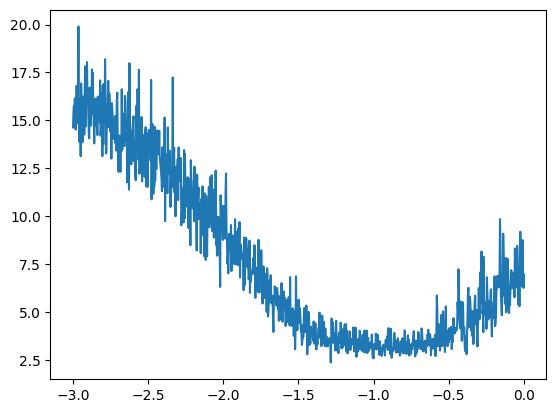

In [104]:
plot.plot(lri, lossi)

A good learing rate exponent is somewhere around -1.0.

So now that we have confidence that 0.1 is a good learning rate we train our model for more iterations using that learning rate.

In [105]:
# reset the params
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad = True

In [108]:
lr = 0.1

for i in range(10000):
    # creating mini batch
    ix = torch.randint(0, X.shape[0], (32, ))

    # forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -lr * p.grad

In [109]:
# overall loss
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y)
loss.item()

2.2983362674713135

**Learning Rate Decay:** when we notice the loss starting to plateau, we reduce the learning rate to improve the trianing.

In [114]:
lr = 0.01

for i in range(10000):
    # creating mini batch
    ix = torch.randint(0, X.shape[0], (32, ))

    # forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -lr * p.grad

In [115]:
# overall loss
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y)
loss.item()

2.2560508251190186

## Creating Training, Validation And Test Splits

In [119]:
def build_dataset(words):
    block_size = 3 
    X, Y = [], []

    for w in words:
        context = [0] * block_size 
        for ch in w + '.':
            ix = chtoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    
    return X, Y

In [118]:
random.shuffle(words)

In [120]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [121]:
n1, n2

(25626, 28829)

In [122]:
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182542, 3]) torch.Size([182542])
torch.Size([22700, 3]) torch.Size([22700])
torch.Size([22904, 3]) torch.Size([22904])


## Training Using New Splits

In [123]:
# reset the params
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad = True

In [129]:
lr = 0.01 # init 0.1 then decay it to 0.01

for i in range(10000):
    # creating mini batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -lr * p.grad

In [131]:
# overall loss on training set
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.304917097091675

In [130]:
# overall loss on validation set
emb = C[Xval] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.30938982963562

Right now the training and validation loss are almost equal. That's how we know we're not overfitting.

## Using A Larger Hidden Layer

Our model is powerful enough to just memorise the data but our training and validation losses are almost equal so we're not overfitting, we're underfitting. That means that our network is very small and we can expect to make performance improvements by scaling up the size of the model.

### Increasing The Number Of Neurons In The Hidden Layer

In [133]:
# init params
C = torch.randn((27, 2))
W1 = torch.randn((6, 300)) # increased from 100 to 300
B1 = torch.randn(300) # 300 biases for each neuron
W2 = torch.randn((300, 27)) # 300 inputs for the next layer
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad = True

In [134]:
sum(p.nelement() for p in parameters)

10281

Our parameters have increased from 3481 to 10281

In [ ]:
lr = 0.1
lossi = []
stepi = []

In [160]:
for i in range(30000):
    # creating mini batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.01 * p.grad # dec to 0.05 

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

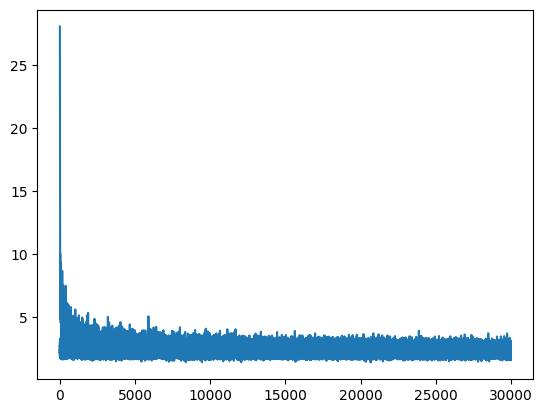

In [161]:
plot.plot(stepi, lossi)

The lines have a bit of a height to them after optimizing. That's because we're using mini batches which add a little bit of noise.

In [162]:
# overall loss on training set
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.223731279373169

In [163]:
# overall loss on validation set
emb = C[Xval] 
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.2455334663391113

After training at `lr=0.1` for 30,000 iterations we had a val loss of 2.5. This shows that we haven't improved the loss by much because our larger network requires more training to converge to a lower loss.

We can continue training it more and check if the loss improves. Another reason can be that our batch size is very low that we have too much noise in the training data and we might want to increase it to have a better gradient.

Even after training a bit more we notice that the loss isn't improving by much. One reason can be that the bottleneck of the network right now could be our 2D embeddings. We might be scramming way too many characters into just a 2D vector and the network isn't really able to use that vector space effectively.

### Visualizing The 2D Character Embeddings Trained By The Network

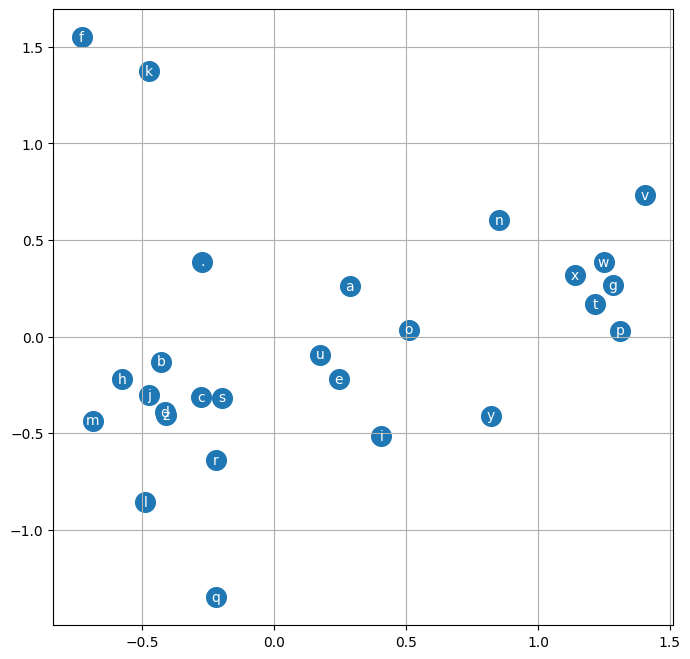

In [169]:
plot.figure(figsize=(8, 8))
plot.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plot.text(C[i, 0].item(), C[i, 1].item(), itoch[i], ha="center", va="center", color="white")
plot.grid("minor")    

## Using Larger Embedding Vectors

Instead of 2D embeddings let's try embeddings of 10 dimensions.

In [183]:
# init params
C = torch.randn((27, 10)) # increased from 2 to 10
W1 = torch.randn((30, 200)) # 3 * 10 so 30 inputs for this layer. Also reduced hidden layer from 300 to 200
B1 = torch.randn(200) 
W2 = torch.randn((200, 27)) 
B2 = torch.randn(27)
parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad = True

In [184]:
sum(p.nelement() for p in parameters)

11897

In [185]:
lr = 0.1
lossi = []
stepi = []

In [186]:
for i in range(50000):
    # creating mini batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # changed from 6 to 30
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # keeping track of log10 of losses

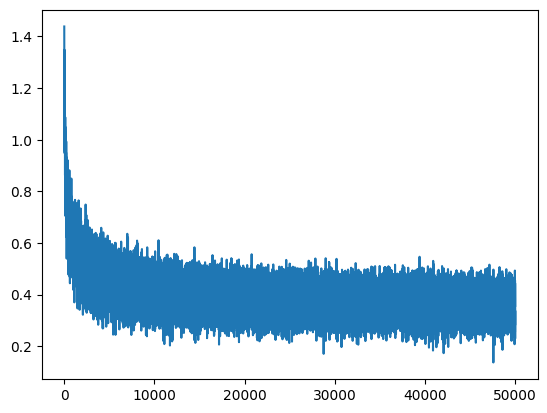

In [187]:
# plotting the log loss
plot.plot(stepi, lossi)

In [188]:
# overall loss on validation set
emb = C[Xval] 
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # changed to 30 from 6
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.3233232498168945

In [193]:
# training on decreased lr
for i in range(50000):
    # creating mini batch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # changed from 6 to 30
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # keeping track of log10 of losses

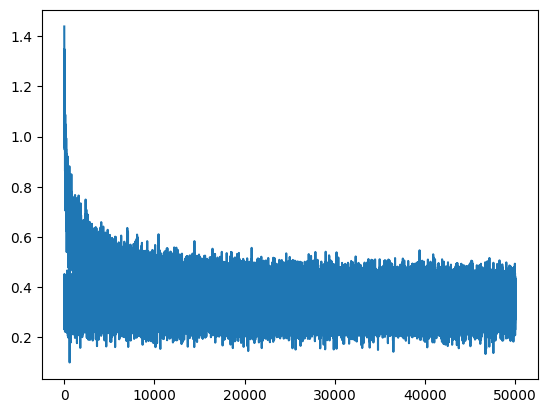

In [196]:
plot.plot(stepi, lossi)

In [194]:
# overall loss on training set
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1435718536376953

In [195]:
# overall loss on validation set
emb = C[Xval] 
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # changed to 30 from 6
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.190290927886963

Notice how the training and the validation losses have started to diverge now so maybe the network is getting good enough now that we are slowly starting to overfit.

We can try out many combinations of hyperparams to further improve the network

- Modify the size of the network
- Size of the embeddings
- Modify the batch size
- Increase the number of characters in a single series
- How many iterations to run
- How the learining rate decays

### Task

At the end of the lecture the loss after training for 200,000 iter at learning rate of 0.1 for first 100k and then 0.01 was 2.12 and 2.17 on training and validation sets resp. The goal is to try to get a better loss by modifying the params.

## Sampling From The Model

In [198]:
for _ in range(20):
    out = []
    context = [0] * block_size # init context with all dots ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoch[i] for i in out))    

ray.
kiv.
kev.
emakie.
ine.
baauri.
kadley.
srious.
juro.
bariina.
meya.
imalykanzae.
toraylinn.
kam.
emyna.
fyre.
jeedlyann.
lurnell.
myishadiaroalina.
koniri.


Our words now look a bit more namelike but we can improve further.